# 1. **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from copy import deepcopy as dc

# 2. **Dataset Feature Engineering**

In [2]:
# Load the data
data = pd.read_csv('ETH-GBP.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-11,226.407333,242.230057,226.108566,238.611618,238.611618,638687437
1,2017-11-12,238.618439,241.910873,226.351990,234.685974,234.685974,1229786537
2,2017-11-13,234.012955,250.373566,233.995117,241.417801,241.417801,794183996
3,2017-11-14,241.453613,259.439453,241.472031,256.617004,256.617004,813012085
4,2017-11-15,256.870087,259.169830,250.541626,253.080017,253.080017,548638008
...,...,...,...,...,...,...,...
2351,2024-04-19,2396.703613,2487.182129,2373.826660,2465.684082,2465.684082,12210717573
2352,2024-04-20,2465.624268,2514.829102,2314.320801,2473.343994,2473.343994,16492835348
2353,2024-04-21,2473.505371,2563.403320,2443.031494,2552.856445,2552.856445,8018954359
2354,2024-04-22,2552.810791,2585.097656,2522.073730,2543.087891,2543.087891,7590900278


In [4]:
# Load the data
data = pd.read_csv('ETH-GBP.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-11,226.407333,242.230057,226.108566,238.611618,238.611618,638687437
1,2017-11-12,238.618439,241.910873,226.351990,234.685974,234.685974,1229786537
2,2017-11-13,234.012955,250.373566,233.995117,241.417801,241.417801,794183996
3,2017-11-14,241.453613,259.439453,241.472031,256.617004,256.617004,813012085
4,2017-11-15,256.870087,259.169830,250.541626,253.080017,253.080017,548638008
...,...,...,...,...,...,...,...
2351,2024-04-19,2396.703613,2487.182129,2373.826660,2465.684082,2465.684082,12210717573
2352,2024-04-20,2465.624268,2514.829102,2314.320801,2473.343994,2473.343994,16492835348
2353,2024-04-21,2473.505371,2563.403320,2443.031494,2552.856445,2552.856445,8018954359
2354,2024-04-22,2552.810791,2585.097656,2522.073730,2543.087891,2543.087891,7590900278


In [5]:
# Select relevant columns
data = data[['Date', 'Close']]

data

,Date,Close
0,2017-11-11,238.611618
1,2017-11-12,234.685974
2,2017-11-13,241.417801
3,2017-11-14,256.617004
4,2017-11-15,253.080017
...,...,...
2351,2024-04-19,2465.684082
2352,2024-04-20,2473.343994
2353,2024-04-21,2552.856445
2354,2024-04-22,2543.087891


<ipython-input-6-cbf215e0cd63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


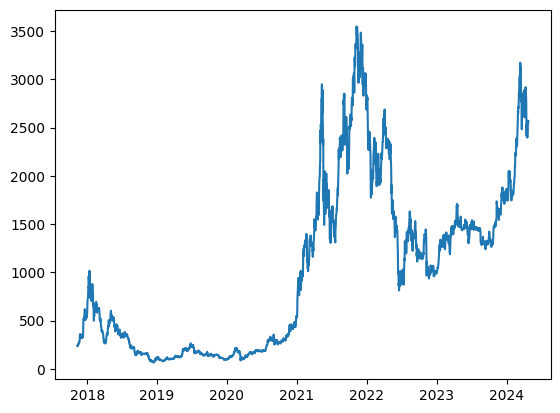

In [6]:
# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Plot the data
plt.plot(data['Date'], data['Close'])
plt.show()

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

device

'cpu'

# 2.1 **Data Preparation for LSTM Module**




In [8]:
# Function to prepare data for LSTM
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    return df

In [9]:
# Prepare data
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)

shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2017-11-18,263.123169,251.603973,250.738007,253.080017,256.617004,241.417801,234.685974,238.611618
2017-11-19,268.514923,263.123169,251.603973,250.738007,253.080017,256.617004,241.417801,234.685974
2017-11-20,276.965485,268.514923,263.123169,251.603973,250.738007,253.080017,256.617004,241.417801
2017-11-21,272.082886,276.965485,268.514923,263.123169,251.603973,250.738007,253.080017,256.617004
2017-11-22,285.903564,272.082886,276.965485,268.514923,263.123169,251.603973,250.738007,253.080017
...,...,...,...,...,...,...,...,...
2024-04-19,2465.684082,2396.721436,2481.704102,2491.952881,2533.711182,2412.219971,2603.385254,2792.003418
2024-04-20,2473.343994,2465.684082,2396.721436,2481.704102,2491.952881,2533.711182,2412.219971,2603.385254
2024-04-21,2552.856445,2473.343994,2465.684082,2396.721436,2481.704102,2491.952881,2533.711182,2412.219971


In [10]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df)

shifted_df_as_np

array([[-0.88729178, -0.89391062, -0.8944082 , ..., -0.89976352,
        -0.90363158, -0.90137593],
       [-0.88419372, -0.88729178, -0.89391062, ..., -0.89103017,
        -0.89976352, -0.90363158],
       [-0.87933809, -0.88419372, -0.88729178, ..., -0.8930625 ,
        -0.89103017, -0.89976352],
       ...,
       [ 0.42837188,  0.38268462,  0.37828329, ...,  0.39337715,
         0.41737116,  0.34756322],
       [ 0.42275895,  0.42837188,  0.38268462, ...,  0.38748828,
         0.39337715,  0.41737116],
       [ 0.43791649,  0.42275895,  0.42837188, ...,  0.33865787,
         0.38748828,  0.39337715]])

In [11]:
shifted_df_as_np.shape

(2349, 8)

In [16]:
# Separate features and target
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X = dc(np.flip(X, axis=1))

X.shape, y.shape

((2349, 7), (2349,))

In [17]:
# Train-test split (80-20)
split_index = int(len(X) * 0.80)

split_index

1879

In [18]:
# Perform Train-Test split on the Dataset
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1879, 7), (470, 7), (1879,), (470,))

In [19]:
# Reshape data for LSTM
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1879, 7, 1), (470, 7, 1), (1879, 1), (470, 1))

In [20]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1879, 7, 1]),
 torch.Size([470, 7, 1]),
 torch.Size([1879, 1]),
 torch.Size([470, 1]))

In [23]:
 # Define dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset

In [24]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. **Modeling**

In [25]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model, loss function, optimizer
model = LSTM(1, 4, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Training function
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')

In [27]:
# Validation function
def validate_one_epoch():
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()
    avg_loss_across_batches = running_loss / len(test_loader)
    print(f'Validation Loss: {avg_loss_across_batches:.3f}')
    print('*****************')

In [28]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch 1, Loss: 0.866
Validation Loss: 0.119
*****************
Epoch 2, Loss: 0.389
Validation Loss: 0.020
*****************
Epoch 3, Loss: 0.090
Validation Loss: 0.044
*****************
Epoch 4, Loss: 0.033
Validation Loss: 0.018
*****************
Epoch 5, Loss: 0.016
Validation Loss: 0.007
*****************
Epoch 6, Loss: 0.011
Validation Loss: 0.007
*****************
Epoch 7, Loss: 0.010
Validation Loss: 0.006
*****************
Epoch 8, Loss: 0.009
Validation Loss: 0.006
*****************
Epoch 9, Loss: 0.009
Validation Loss: 0.005
*****************
Epoch 10, Loss: 0.008
Validation Loss: 0.005
*****************
Epoch 11, Loss: 0.008
Validation Loss: 0.005
*****************
Epoch 12, Loss: 0.007
Validation Loss: 0.004
*****************
Epoch 13, Loss: 0.006
Validation Loss: 0.004
*****************
Epoch 14, Loss: 0.006
Validation Loss: 0.004
*****************
Epoch 15, Loss: 0.005
Validation Loss: 0.003
*****************
Epoch 16, Loss: 0.005
Validation Loss: 0.003
*****************
E

In [29]:
# Calculate predictions for both training and testing data
with torch.no_grad():
    predicted_train = model(X_train.to(device)).cpu().numpy()
    predicted_test = model(X_test.to(device)).cpu().numpy()

In [30]:
# Inverse transform the predictions
train_predictions = np.zeros((X_train.shape[0], lookback + 1))
train_predictions[:, 0] = predicted_train.flatten()
train_predictions = scaler.inverse_transform(train_predictions)[:, 0]

train_predictions

array([ 248.86774619,  253.05817516,  257.60876774, ..., 1048.16883519,
       1051.56953904, 1060.52072519])

In [31]:
# Inverse transform the predictions
test_predictions = np.zeros((X_test.shape[0], lookback + 1))
test_predictions[:, 0] = predicted_test.flatten()
test_predictions = scaler.inverse_transform(test_predictions)[:, 0]

test_predictions

array([1074.35258474, 1088.28983779, 1113.49465185, 1136.0243797 ,
       1160.68313924, 1209.76787977, 1238.07371085, 1264.43142191,
       1272.87659477, 1256.58489657, 1259.11776379, 1297.13758721,
       1304.45460357, 1309.44679077, 1313.94494593, 1293.02366189,
       1298.61838664, 1297.11782593, 1295.59283593, 1285.88620867,
       1306.3818731 , 1290.6177648 , 1292.41692313, 1308.80675347,
       1325.78247208, 1351.79075597, 1366.63407155, 1361.97357305,
       1355.60706914, 1371.54327174, 1369.97414302, 1328.43069124,
       1298.54048258, 1290.98882046, 1277.18662876, 1262.58599832,
       1271.39621028, 1325.02231109, 1344.43499506, 1373.84470894,
       1388.8128681 , 1394.16993879, 1404.72287793, 1388.97303302,
       1378.26843513, 1377.04790371, 1363.44394723, 1351.24356039,
       1362.05339618, 1358.74932033, 1348.47423207, 1365.39756513,
       1371.50354171, 1341.28812772, 1325.84326007, 1316.24410099,
       1311.70134031, 1316.79264511, 1307.63948934, 1264.71762

In [32]:
# Inverse transform the predictions
actual_train = np.zeros((X_train.shape[0], lookback + 1))
actual_train[:, 0] = y_train.flatten()
actual_train = scaler.inverse_transform(actual_train)[:, 0]

actual_train

array([ 263.12315068,  268.51492032,  276.96548734, ..., 1045.45676791,
       1062.17579733, 1084.66895903])

In [33]:
# Inverse transform the predictions
actual_test = np.zeros((X_test.shape[0], lookback + 1))
actual_test[:, 0] = y_test.flatten()
actual_test = scaler.inverse_transform(actual_test)[:, 0]

actual_test

array([1099.73110098, 1141.50660518, 1160.62380353, 1186.83301972,
       1267.8502273 , 1270.08812757, 1291.60800727, 1276.37097021,
       1227.43493203, 1252.82615565, 1339.37512158, 1313.35781285,
       1312.54588871, 1315.3077482 , 1262.28615589, 1298.67004605,
       1291.28575835, 1290.81345854, 1270.0384391 , 1327.49765794,
       1269.11131862, 1288.98069047, 1325.33226756, 1344.6070375 ,
       1381.76050249, 1382.93567633, 1354.78331935, 1343.94018502,
       1387.10082019, 1367.53297645, 1276.39768165, 1255.69325304,
       1276.46376006, 1257.1356191 , 1240.4306456 , 1278.8327798 ,
       1390.4913322 , 1369.65651025, 1407.16002481, 1404.69909696,
       1397.81651759, 1414.33557426, 1369.24131587, 1364.01380864,
       1373.95936068, 1346.82118274, 1335.04750472, 1373.04894133,
       1354.89576674, 1334.58241441, 1383.10351755, 1378.57727647,
       1303.77748145, 1301.97277336, 1300.70556175, 1303.42530534,
       1320.65195592, 1294.67992697, 1206.65073215, 1206.65073

In [51]:
# Evaluation Metrics
train_mape = np.mean(np.abs((actual_train - train_predictions) / actual_train)) * 100
train_r2 = r2_score(actual_train, train_predictions)

test_mape = np.mean(np.abs((actual_test - test_predictions) / actual_test)) * 100
test_r2 = r2_score(actual_test, test_predictions)

In [52]:
# Print the results of evaluation metrics
print("Training Metrics:")
print(f"MAPE: {train_mape:.4f}%")
print(f"R2 Score: {train_r2:.4f}")

print("\nTesting Metrics:")
print(f"MAPE: {test_mape:.4f}%")
print(f"R2 Score: {test_r2:.4f}")

Training Metrics:
MAPE: 5.6188%
R2 Score: 0.9943

Testing Metrics:
MAPE: 2.1792%
R2 Score: 0.9845


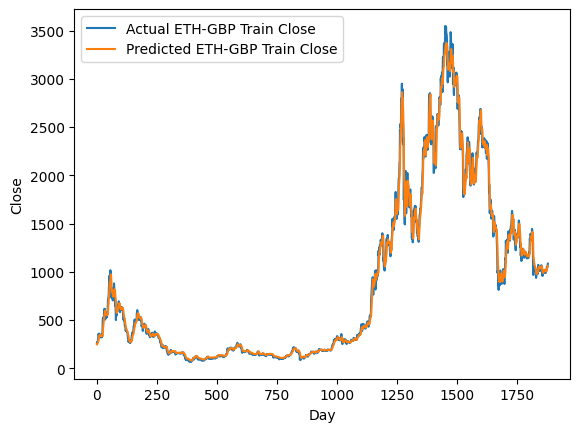

In [49]:
# Plot training results
plt.plot(actual_train, label='Actual ETH-GBP Train Close')
plt.plot(train_predictions, label='Predicted ETH-GBP Train Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

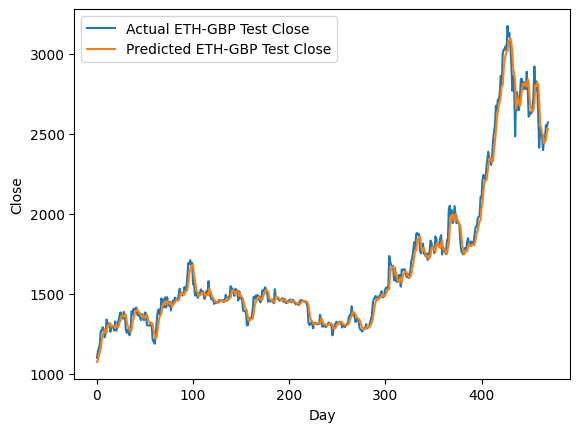

In [50]:
# Plot testing results
plt.plot(actual_test, label='Actual ETH-GBP Test Close')
plt.plot(test_predictions, label='Predicted ETH-GBP Test Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()